In [4]:
import pandas as pd
import numpy as np

stocks = pd.read_csv("data/stocks_ti.csv")

import warnings

warnings.filterwarnings("ignore")


### Classifiers

I'm going to run Logistic Regression, Random Forest, and XGBoost classifiers on the data. Each model will be evaluated on the following datasets:
1. Previous days SPY returns
2. Previous subset plus previous days sector ETFs returns
3. Previous subset plus sentiment scores
4. Data from 2. plus technical indicators
5. Full dataset comprising sector ETFs, sentiment scores, and technical indicators

The previous process will be iterated trying to predict 1 day, 5 day, 13 day and 21 day returns.

In [14]:
from utils import prep_classifier_data, feature_type_map

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

# dictionary to store tuple of (pred, confusion_matrix, classifier) for each day, for each feature type, for each model
models_key = {
    "logistic_regression": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "random_forest": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
    "xgboost": {
        "spy_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 13: None, 21: None},
    },
}

# loop through each day and each feature type
for i, day_no in enumerate([1, 5, 13, 21]):
    for j, features in enumerate([columns1, columns2, columns3, columns4, columns5]):
        features_type = [
            "spy_returns",
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ][j]

        # prep data
        X_train, X_test, y_train, y_test = prep_classifier_data(
            stocks[features].copy(), day_no
        )

        ## models
        from utils import (
            logistic_regression,
            random_forest_classifier,
            xgboost_classifier,
        )

        # logistic regression
        print(f"Logistic Regression on {day_no} day(s) with {features_type}...")
        models_key["logistic_regression"][features_type][day_no] = logistic_regression(
            X_train, X_test, y_train, y_test
        )

        # random forest
        print(f"Random Forest on {day_no} day(s) with {features_type}...")
        models_key["random_forest"][features_type][day_no] = random_forest_classifier(
            X_train, X_test, y_train, y_test
        )

        # xgboost
        print(f"XGBoost on {day_no} day(s) with {features_type}...")
        models_key["xgboost"][features_type][day_no] = xgboost_classifier(
            X_train, X_test, y_train, y_test
        )


Logistic Regression on 1 day(s) with spy_returns...
Accuracy:  0.548
Random Forest on 1 day(s) with spy_returns...
Accuracy:  0.54
XGBoost on 1 day(s) with spy_returns...
Accuracy:  0.532
Logistic Regression on 1 day(s) with sector_returns...
Accuracy:  0.544
Random Forest on 1 day(s) with sector_returns...
Accuracy:  0.52
XGBoost on 1 day(s) with sector_returns...
Accuracy:  0.492
Logistic Regression on 1 day(s) with sector_returns_sentiment...
Accuracy:  0.552
Random Forest on 1 day(s) with sector_returns_sentiment...
Accuracy:  0.524
XGBoost on 1 day(s) with sector_returns_sentiment...
Accuracy:  0.532
Logistic Regression on 1 day(s) with sector_returns_technical...
Accuracy:  0.5140562248995983
Random Forest on 1 day(s) with sector_returns_technical...
Accuracy:  0.5301204819277109
XGBoost on 1 day(s) with sector_returns_technical...
Accuracy:  0.4979919678714859
Logistic Regression on 1 day(s) with all_features...
Accuracy:  0.5180722891566265
Random Forest on 1 day(s) with all_fe

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


def plot_all_confusion_matrices(feature_types_dict, title):
    fig, axes = plt.subplots(5, 4, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    for i, (feature_type, days_dict) in enumerate(feature_types_dict.items()):
        for j, (days, results) in enumerate(days_dict.items()):
            if results is not None:
                cm = results[1]
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(
                    ax=axes[i, j], cmap="Blues", values_format=".0f", colorbar=False
                )
                axes[i, j].set_title(
                    f"Feature type: {feature_type} \n Predicting {days} day(s) return",
                    fontsize=10,
                )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave some space at the top for the title
    plt.show()


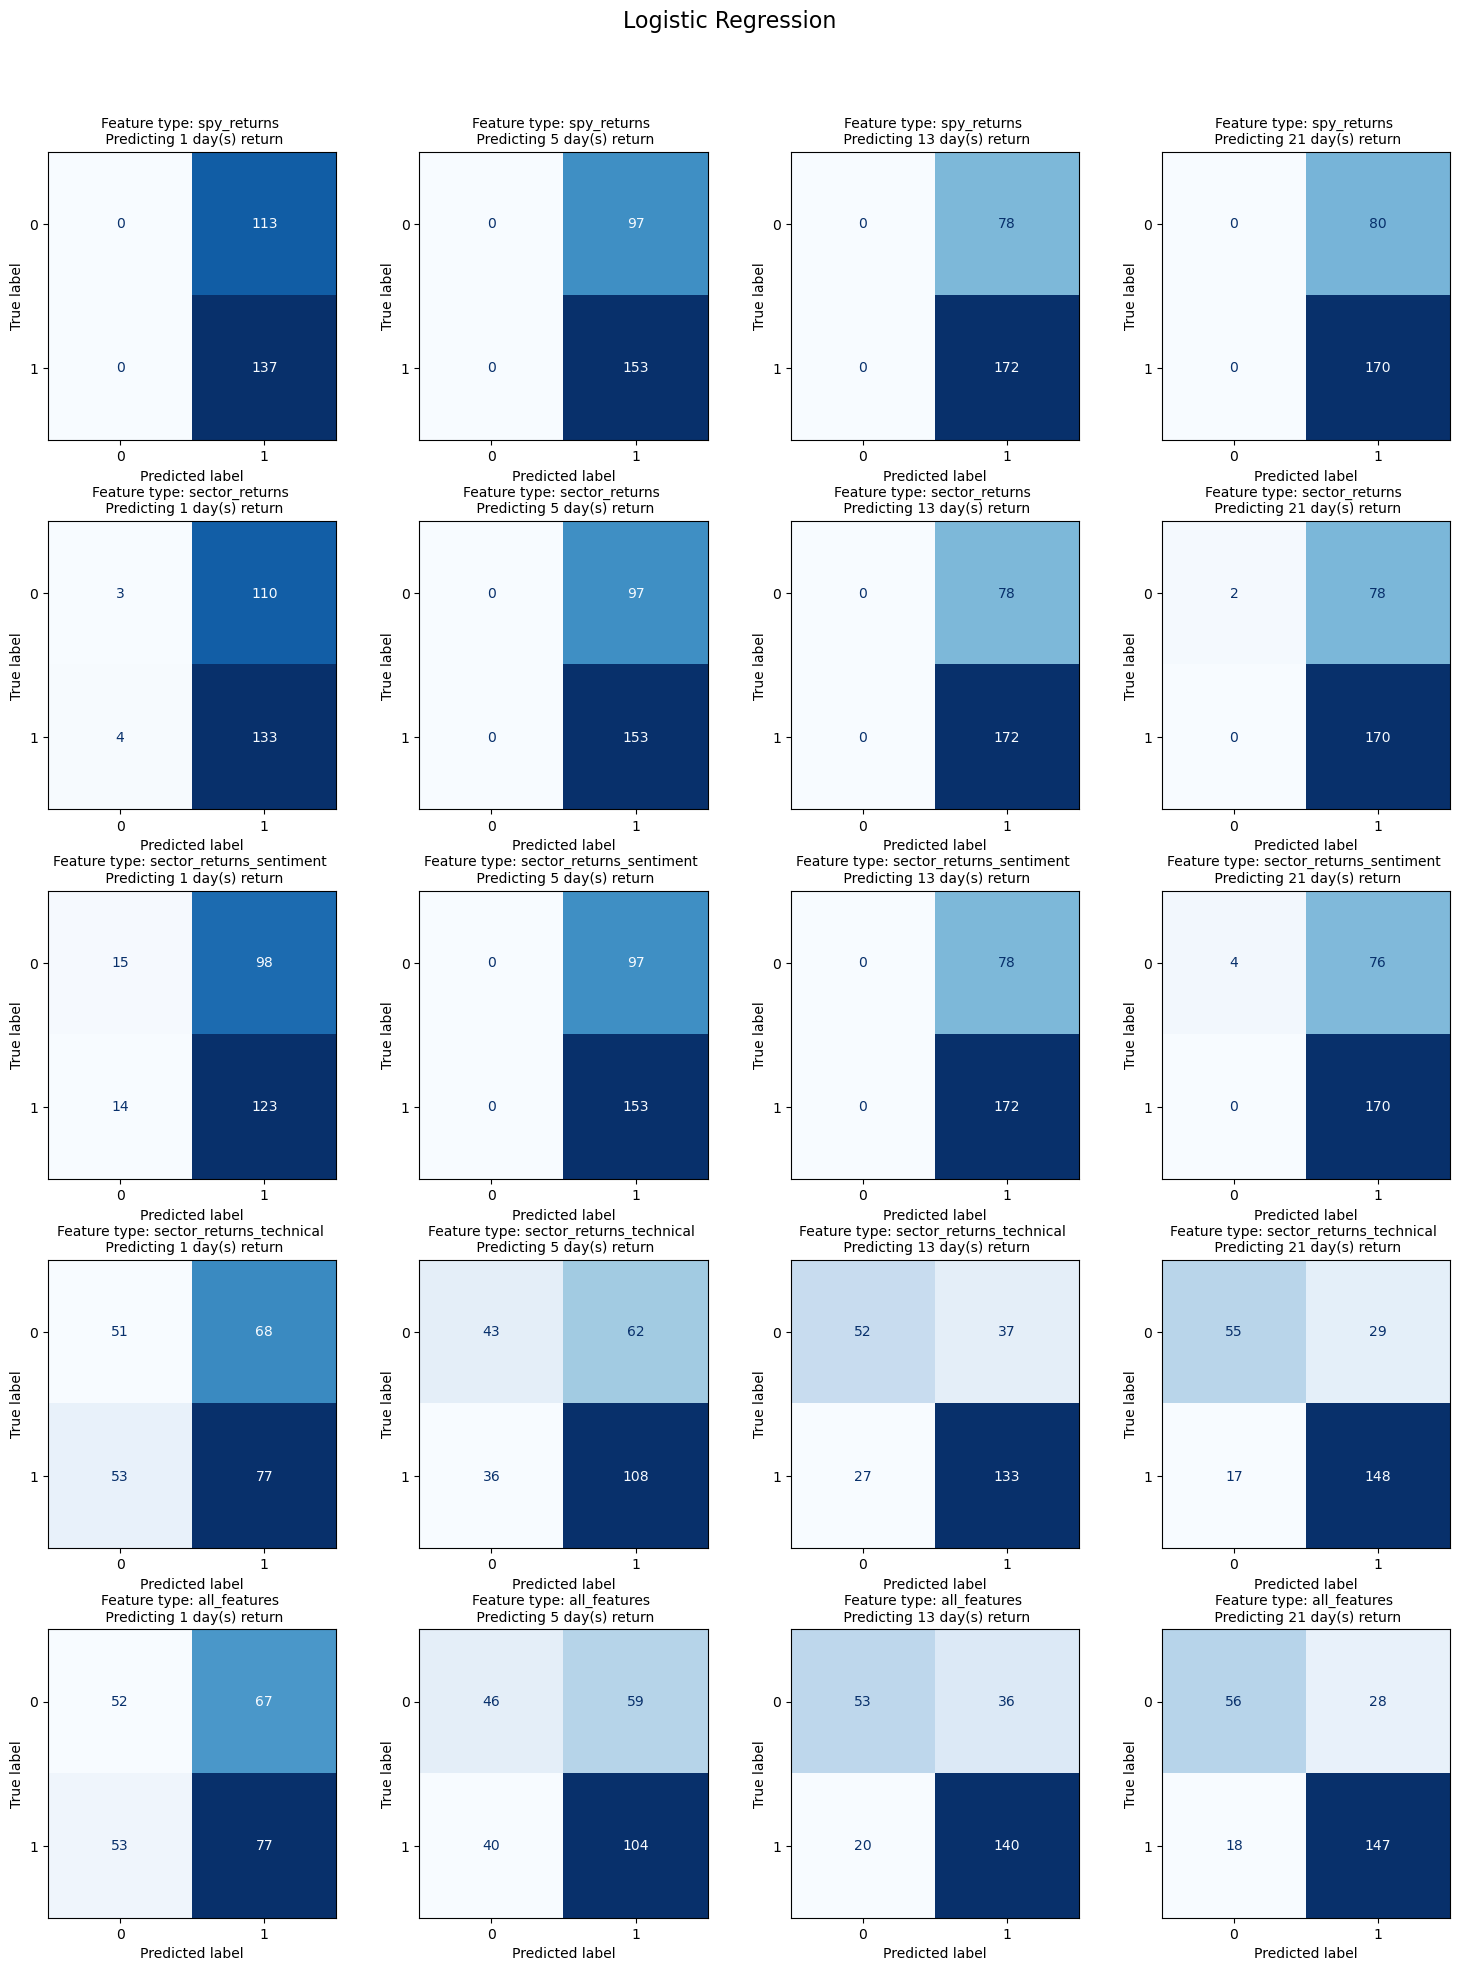

In [47]:
plot_all_confusion_matrices(models_key["logistic_regression"], "Logistic Regression")


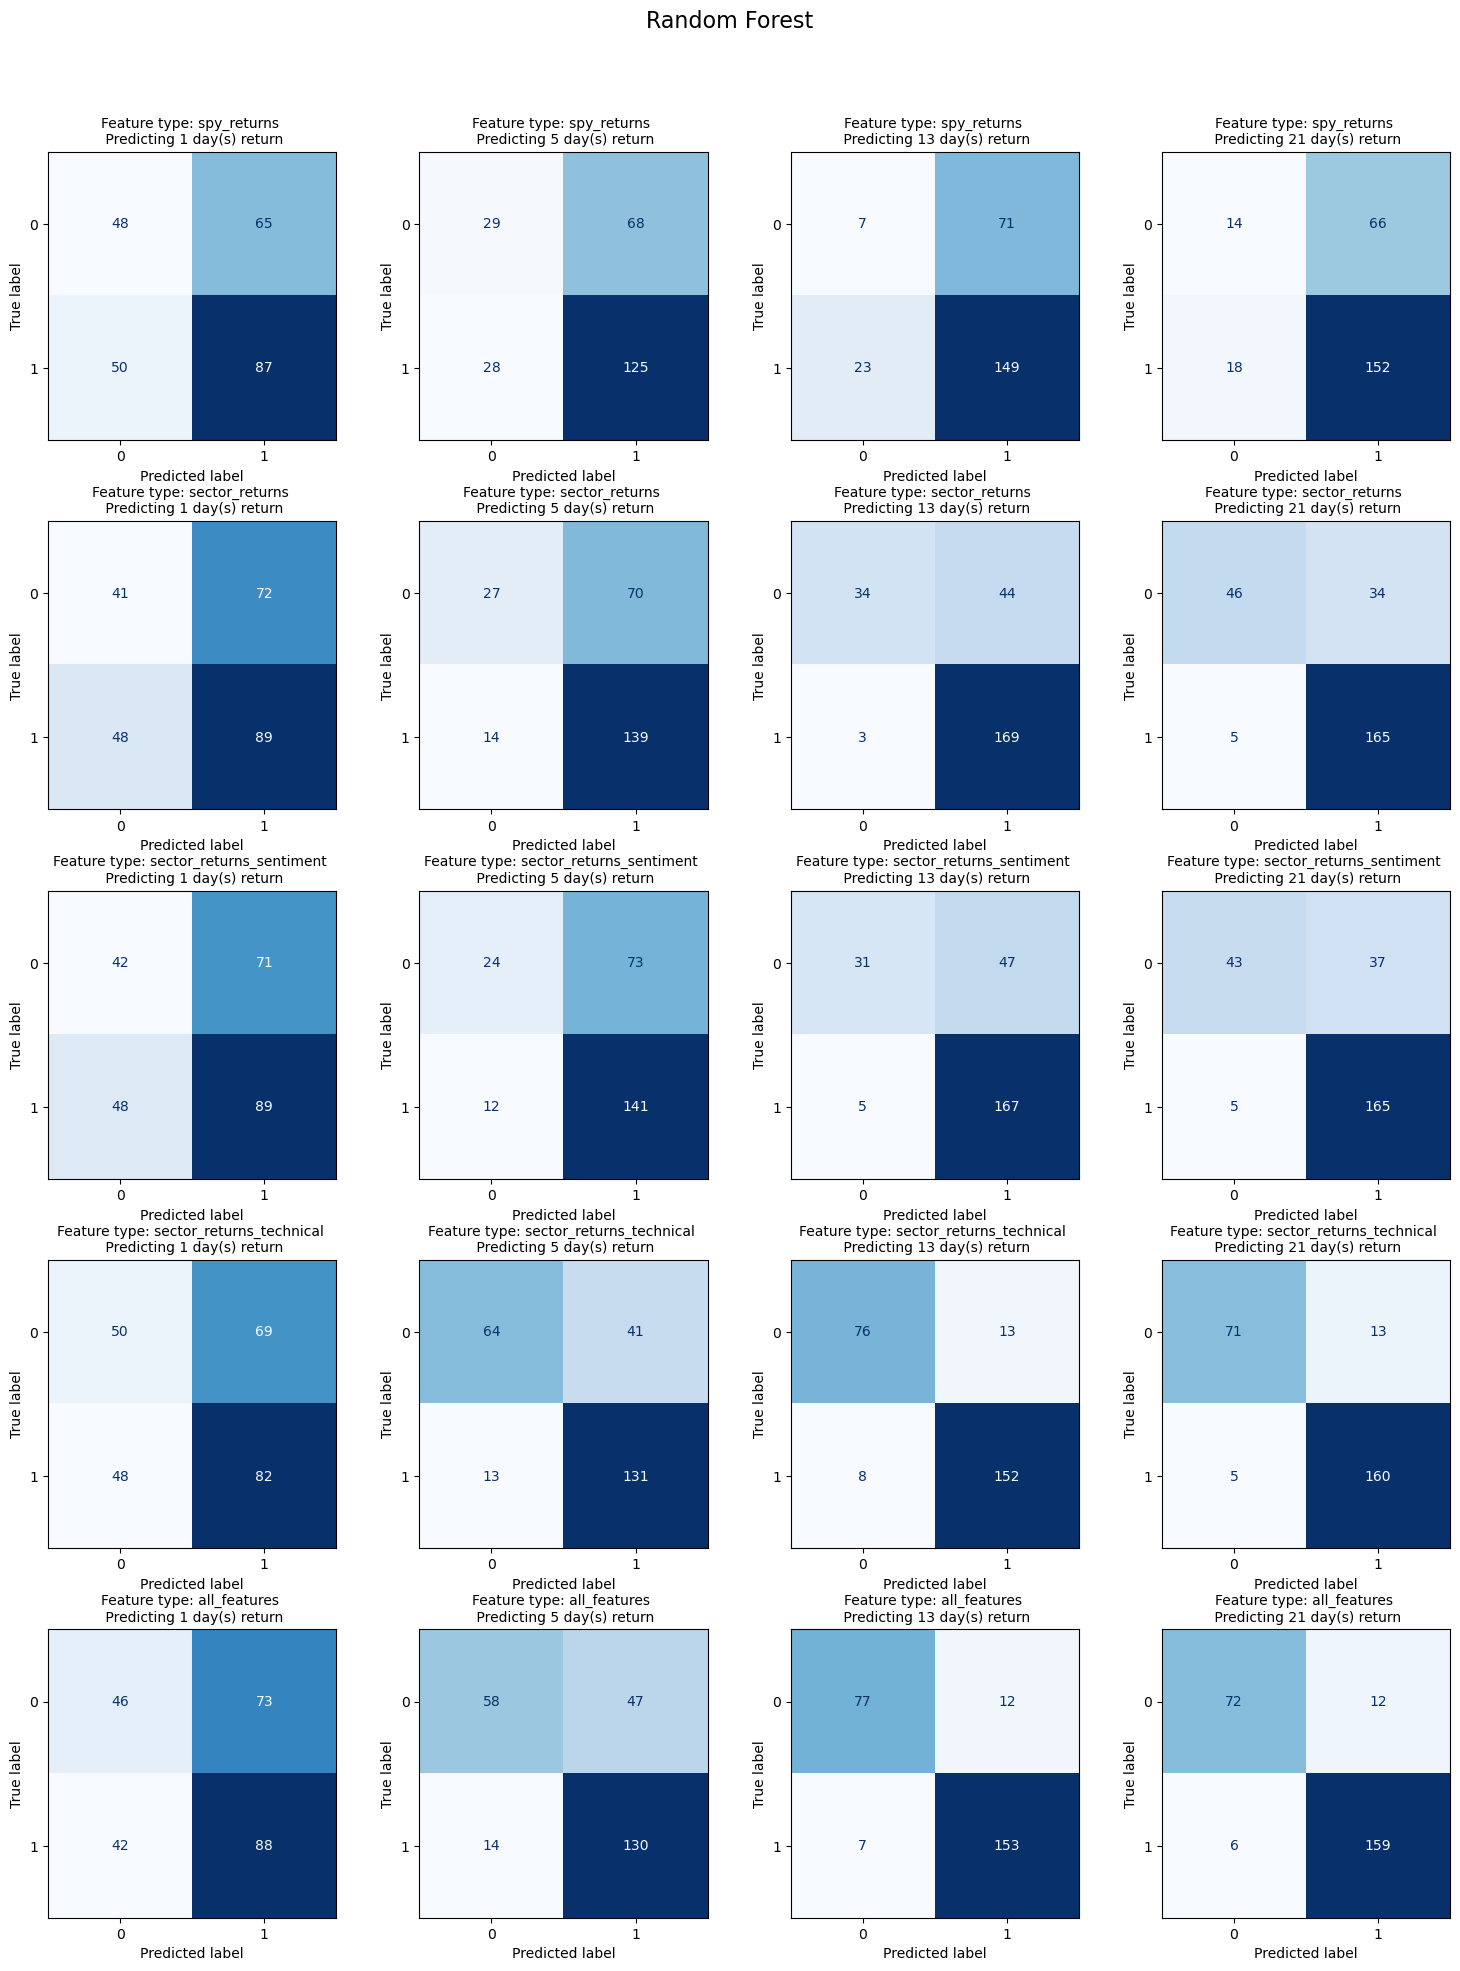

In [48]:
plot_all_confusion_matrices(models_key["random_forest"], "Random Forest")


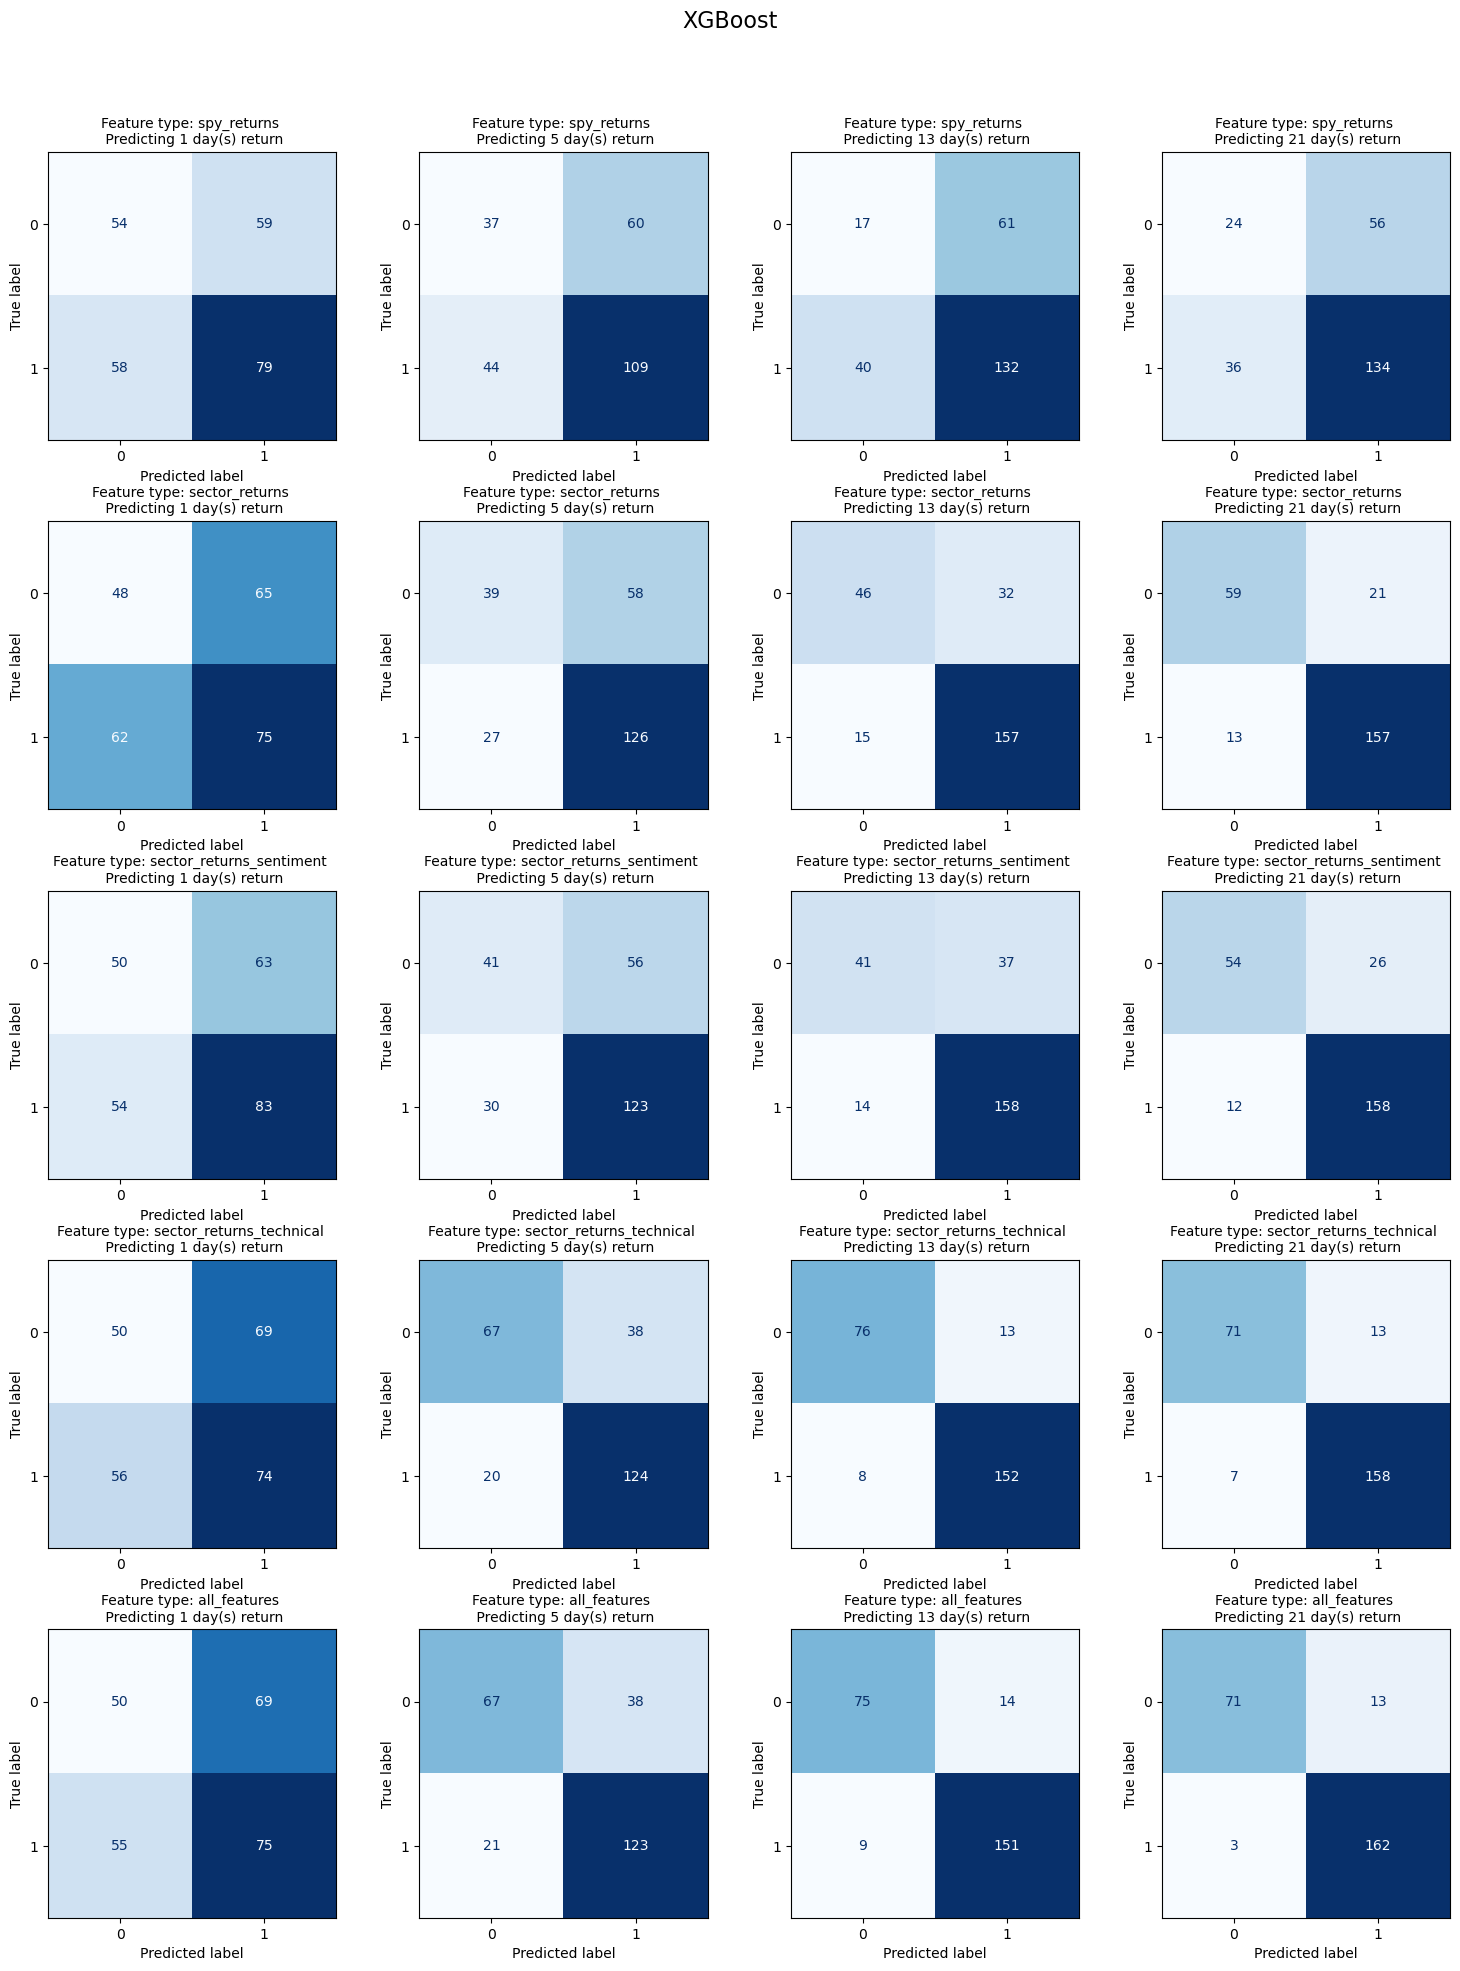

In [49]:
plot_all_confusion_matrices(models_key["xgboost"], "XGBoost")
